Code from [scale embedding-decoder](https://git.scc.kit.edu/scale/research/embedding-decoder) with slight changes

In [1]:
import wandb
from wandb.keras import WandbCallback
import tensorflow as tf
import networkx as nx
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mpl
import seaborn as sns

from util.map import Map
from util.generate_points import list_to_dict, gen_square, gen_disc

wandb.login()

wandb: Currently logged in as: hydrofin (hydrofin-personal). Use `wandb login --relogin` to force relogin


True

In [2]:
wandb.init(project="embedding-eval-framework", entity="hydrofin")
wandb.run

wandb: Currently logged in as: hydrofin. Use `wandb login --relogin` to force relogin


In [3]:
args = Map(
    batch_size = 64,
    epochs = 50,
    random_seed = None,
    graph_size = 1000,
    graph_average_degree = 10,
    rg_radius = 0.05,
    layers = 10,
    layer_size = 16,
    train_size = 0.7
)

In [4]:
rg_radius = args.rg_radius if args.rg_radius > 0 else math.sqrt(args.graph_average_degree / (args.graph_size * math.pi))

pos = list_to_dict(gen_disc(args.graph_size))
nx_graph = nx.random_geometric_graph(args.graph_size, rg_radius, pos=pos)  # not based on rng seed yet!
largest_component = max(nx.connected_components(nx_graph), key=len)

Nodes: 1000
Edges: 4772
Average Degree: 9.544
Largest Component Size: 1000


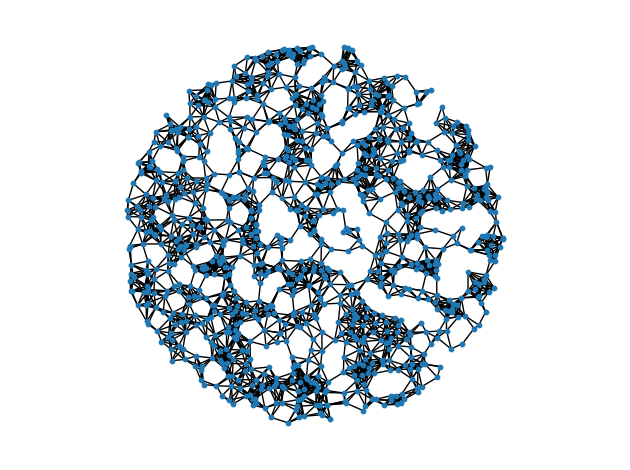

<Figure size 640x480 with 0 Axes>

In [5]:
print(f'Nodes: {nx_graph.number_of_nodes()}')
print(f'Edges: {nx_graph.number_of_edges()}')
print(f'Average Degree: {2.0 * nx_graph.number_of_edges() / nx_graph.number_of_nodes()}')
print(f'Largest Component Size: {len(largest_component)}')

fig = plt.figure()
ax = fig.add_subplot()

nx.draw_networkx(nx_graph, pos, ax=ax, node_size=10, with_labels=False, labels={})
plt.axis('off')
fig.set_facecolor('w')

plt.axis('equal')
fig.tight_layout()
plt.show()

wandb.log({
    "generated_graph": wandb.Image(plt)
})

In [6]:
#graph_nodes_pos = [ node['pos'] for node in  ]

graph_nodes = nx.nodes(nx_graph)

# all combinations of x and y (with x > y)
print("generating edge pairs...", end='')
ds_edge_pairs = [ [ei0, ei1] for ei0 in range(nx_graph.number_of_nodes()) for ei1 in range(ei0 + 1, nx_graph.number_of_nodes()) ]
print(f"DONE generated {len(ds_edge_pairs)} pairs")
ds_edges_pos = [ [graph_nodes[ei0]['pos'][0], graph_nodes[ei0]['pos'][1], graph_nodes[ei1]['pos'][0], graph_nodes[ei1]['pos'][1]] for [ei0, ei1] in tqdm(ds_edge_pairs, desc="mapping edge positions") ]
ds_edges_label = [ 1 if nx_graph.has_edge(ei0, ei1) else 0 for [ei0, ei1] in tqdm(ds_edge_pairs, desc="creating labels for edges") ]

def z2polar(z: (float, float)) -> [float, float]:
    rho = np.sqrt(z[0]**2 + z[1]**2)
    phi = np.arctan2(z[1], z[0])
    return [rho, phi]

def zs2polars(zs: [(float, float)]) -> [float, float]:
    return np.array([ z2polar(z) for z in zs ]).flatten()

generating edge pairs...DONE generated 499500 pairs


creating labels for edges: 100%|██████████| 499500/499500 [00:00<00:00, 2185335.43it/s]


In [7]:
# tensorflow

# generate dataset from graph from previous
full_dataset = tf.data.Dataset.from_tensor_slices((ds_edges_pos, ds_edges_label)).batch(args.batch_size)

# split dataset
full_dataset = full_dataset.shuffle(nx_graph.number_of_nodes())
train_dataset = full_dataset.take(int(args.train_size * nx_graph.number_of_nodes()))
test_dataset = full_dataset.take(int((1 - args.train_size) * nx_graph.number_of_nodes()))

# build model(s)
model_array = [
    tf.keras.layers.InputLayer(input_shape=(4))] #possible TODO get inputshape dynamically

for i in range(args.layers):
    model_array.append(tf.keras.layers.Dense(args.layer_size, activation='relu')) #make size depending of graph dimensionality? Or would that against the idea?

model_array.append(tf.keras.layers.Flatten())
model_array.append(tf.keras.layers.Dense(1, activation='sigmoid'))

dense_model = tf.keras.Sequential(model_array)

dense_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(), # TODO try other loss function
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(thresholds=0),
        tf.keras.metrics.AUC(
            curve="PR"
        ),
        #tfma.metrics.AUCPrecisionRecall()
    ]
)

# train
train_history = dense_model.fit(train_dataset, epochs=args.epochs, callbacks=[WandbCallback()])

# evaluate
test_loss, test_acc, e1, e2 = dense_model.evaluate(test_dataset, verbose=0)
dense_model.summary()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
700/700 [==============================] - 3s 1ms/step - loss: 0.0911 - accuracy: 0.9898 - recall: 1.0000 - auc: 0.0122
Epoch 2/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0410 - accuracy: 0.9904 - recall: 1.0000 - auc: 0.1222
Epoch 3/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0215 - accuracy: 0.9898 - recall: 1.0000 - auc: 0.3706
Epoch 4/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0162 - accuracy: 0.9919 - recall: 1.0000 - auc: 0.6034
Epoch 5/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0139 - accuracy: 0.9941 - recall: 1.0000 - auc: 0.7028
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0124 - accuracy: 0.9949 - recall: 1.0000 - auc: 0.7281
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0110 - accuracy: 0.9952 - recall: 1.0000 - auc: 0.8215
Epoch 8/50
700/700 [==============================] - 1s 1ms/step - loss: 0.0110 - 

In [8]:
predictions = dense_model.predict(ds_edges_pos) # cartesian
edge_prediction = [pred[0] for pred in predictions]

15610/15610 [==============================] - 10s 646us/step


In [9]:
pred_graph = nx.create_empty_copy(nx_graph, with_data=True)
edges = [ pair for pair, prediction in zip(ds_edge_pairs, edge_prediction) if (prediction >= 0.1) ] # and (pair[0] != pair[1])
pred_graph.add_edges_from(edges)

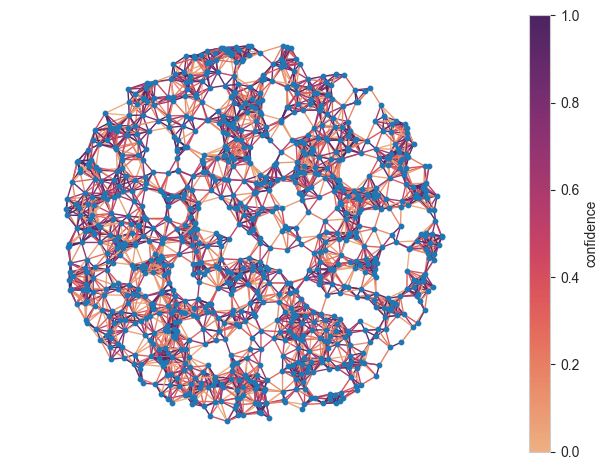

In [10]:
c1='#1f77b4' #blue
c2='green' #green

colors = np.array([ pred for pred in edge_prediction if (pred >= 0.1)])
colormap = sns.color_palette("flare", as_cmap=True)
options = {
    #"node_color": "#A0CBE2",
    "edge_color": colors,
    "node_size": 10,
    "edge_cmap": colormap,
    "with_labels": False,
}

fig = plt.figure()
ax = fig.add_subplot()
fig.colorbar(mpl.cm.ScalarMappable(cmap=colormap), ax=ax, label="confidence")

nx.draw_networkx(pred_graph, pos, ax=ax, **options, label="reconstructed graph")

# Setting it to how it was looking before.
plt.axis('off')
plt.axis('equal')
fig.set_facecolor('w')

#plt.legend()

fig.tight_layout()
plt.show()

In [11]:
wandb.log({
    "predicted_graph": wandb.Image(plt)
})

<Figure size 640x480 with 0 Axes>

In [12]:
wandb.finish()

accuracy,▁▂▁▃▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇█▇▇█▇██▇██▇
auc,▁▂▄▅▆▇▇▇▇███▇███████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.9967
auc,0.91287
epoch,49
loss,0.0074
recall,1.0


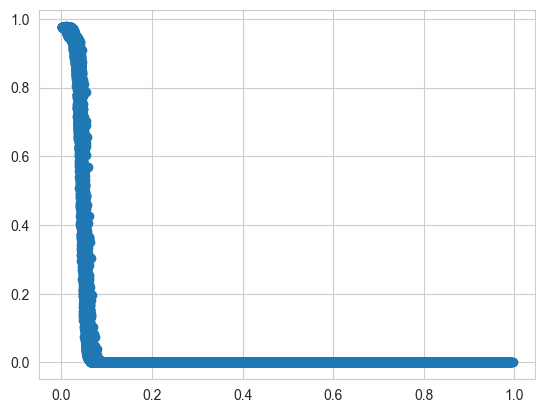

In [77]:
distances = [math.dist([px, py], [qx, qy]) for [px, py, qx, qy] in ds_edges_pos]
fig, ax = plt.subplots()
ax.scatter(distances, edge_prediction)
plt.show()

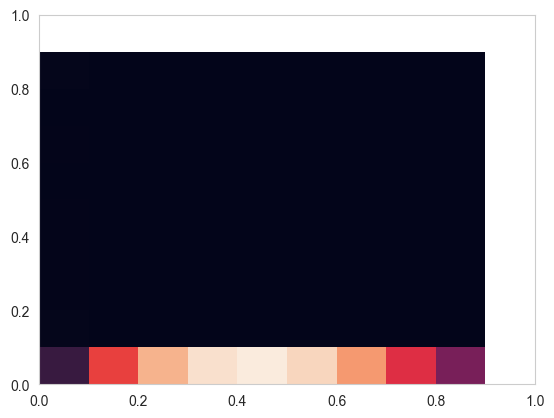

In [15]:
fig, ax = plt.subplots()
ax.hist2d([dist for dist in distances], edge_prediction, bins=(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)))
ax.set(xlim=(0, 1), ylim=(0, 1))

plt.show()

In [78]:
import random
def gen_pts(d: float):
    while True:
        px, py = random.uniform(0, 1), random.uniform(0, 1)
        v = np.random.random(2)
        vd = (v / np.linalg.norm(v)) * d
        [qx, qy] = [px, py] + vd
        if math.dist([px, py], [0.5, 0.5]) <= 0.5 and math.dist([qx, qy], [0.5, 0.5]) <= 0.5:
            return [px, py, qx, qy]

In [79]:
test_distances = np.arange(0, 1, 0.01)
dist_dup = 10
test_edges = [(d, gen_pts(d)) for d in np.tile(test_distances, dist_dup)]
test_edges

[(0.0,
  [0.9568183062851794,
   0.5882038716107283,
   0.9568183062851794,
   0.5882038716107283]),
 (0.01,
  [0.39872615162662106,
   0.7543624715875848,
   0.40544122897805523,
   0.761772447037224]),
 (0.02,
  [0.5821515471268509,
   0.6647426244789084,
   0.6009764352844198,
   0.6714971478414428]),
 (0.03,
  [0.5876429292297666,
   0.13225473038185998,
   0.5960769363788578,
   0.161044789836628]),
 (0.04,
  [0.838494041479456,
   0.24743063905823137,
   0.8752993685904094,
   0.26309486250708847]),
 (0.05,
  [0.6220886222554437,
   0.40338873441078804,
   0.6339387368689218,
   0.4519641889495511]),
 (0.06,
  [0.5371899452632457,
   0.053690975590252155,
   0.5570683548427503,
   0.11030235989225859]),
 (0.07,
  [0.8631475684430807,
   0.26777557273860664,
   0.9178352230882719,
   0.31147065746684927]),
 (0.08,
  [0.41355916543583227,
   0.6527302359609526,
   0.4596432618690421,
   0.7181233247084235]),
 (0.09,
  [0.4318981882102608,
   0.4552367349431856,
   0.515319953784831

In [80]:
test_predictions = dense_model.predict([edge for (_, edge) in test_edges]) # cartesian
test_edge_prediction = [pred[0] for pred in test_predictions]
len(test_edges), len(test_edge_prediction)

32/32 [==============================] - 0s 710us/step


(1000, 1000)

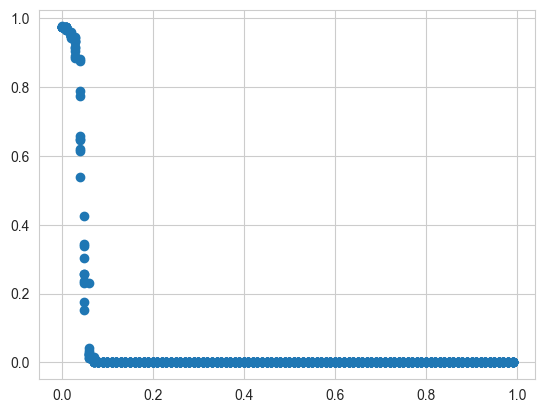

In [81]:
fig, ax = plt.subplots()
ax.scatter([d for (d, _) in test_edges], test_edge_prediction)
plt.show()

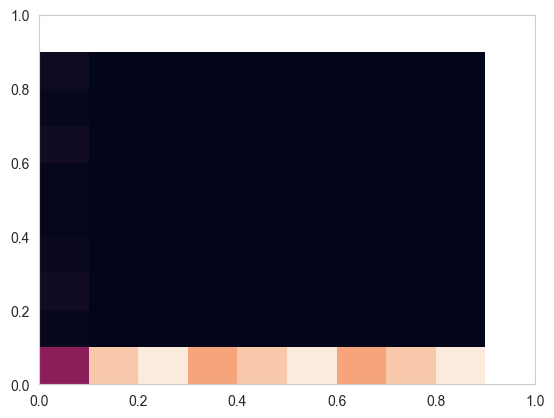

In [82]:
fig, ax = plt.subplots()
ax.hist2d([d for (d, _) in test_edges], test_edge_prediction, bins=(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)))
ax.set(xlim=(0, 1), ylim=(0, 1))

plt.show()